In [5]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [6]:
%%R

#install.packages("tibble")
#install.packages("dplyr")
#install.packages(ggplot2)
#install.packages("caret")
#install.packages("glmnet")

library(tibble)
library(dplyr)
library(ggplot2)
library(caret)
library(pROC)
library(ROSE)
library(glmnet)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Need help getting started? Try the R Graphics Cookbook:
https://r-graphics.org
Loading required package: lattice
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loaded ROSE 0.0-4

Loading required package: Matrix
Loaded glmnet 4.1-8


In [ ]:
%%R

binary_driving_mode <- function (df_chassis) {
    result <- ifelse(df_chassis$drivingMode == "COMPLETE_AUTO_DRIVE", 1, 0)

    return(result)
}


merge_chassis_pose <- function (df_chassis, df_pose) {
    
    
    df_chassis <- df_chassis[order(df_chassis$time), ]
    df_pose <- df_pose[order(df_pose$time), ]
    
    #make sure data is sorted by time fist

    chassis_time_arr <- df_chassis$time
    pose_time_arr <- df_pose$time

    matched_vector <- c()

    for (chassis_time in chassis_time_arr) {
        abs_time_diff_arr <- abs(pose_time_arr - chassis_time)

        min_index <-  which(abs_time_diff_arr == min(abs_time_diff_arr))
        
        matched_vector <-  c(matched_vector, pose_time_arr[min_index])
    }


    #df_chassis$matched <- df_pose$time[which(abs(pose_time_arr - df_chassis$time) == min(abs(pose_time_arr - df_chassis$time)))]
    df_chassis$matched <-  matched_vector
    df_pose$matched <-  df_pose$time


    return (list(df_chassis = df_chassis, df_pose = df_pose))


}

latlongStdDev <- function(df_pose){
    x <- df_pose["latitudeStdDev"]
    y <- df_pose["longitudeStdDev"]
    r <- sqrt(x^2 + y^2)

    return(r)

}


In [3]:
%%R
# Defining GMIDs for Blue Routes
# Am creating a list of GMIDs for processing
blue_route_gmIDs  <- c(
    "20f0b890-ec64-11ee-b297-3b0ad9d5d6c6",
"39ba7438-d0d5-11ee-9435-f7e542e2436c",
"ba28b352-ec8f-11ee-b297-3b0ad9d5d6c6",
"cf6fdf3a-eaa3-11ee-b297-3b0ad9d5d6c6",
"57d240d6-ea4d-11ee-b297-3b0ad9d5d6c6",
"cb205756-ec43-11ee-b297-3b0ad9d5d6c6",
"90101c36-a621-11ee-88ec-eb6a8d5269b4",
"71a18322-ecab-11ee-b297-3b0ad9d5d6c6",
"326699c2-ecd8-11ee-b297-3b0ad9d5d6c6",
"75f83e28-eb77-11ee-b297-3b0ad9d5d6c6",
"88180f82-ed4f-11ee-9385-ef789ffde1d3",
"f6ac3c82-a445-11ee-88ec-eb6a8d5269b4",
"c7c02bda-ebe0-11ee-b297-3b0ad9d5d6c6",
"b224ef9c-ec10-11ee-b297-3b0ad9d5d6c6",
"c335d84c-a45c-11ee-88ec-eb6a8d5269b4",
"60546ef4-edaa-11ee-9385-ef789ffde1d3",
"59c189d8-ed54-11ee-9385-ef789ffde1d3",
"af10e22a-ebb1-11ee-b297-3b0ad9d5d6c6",
"9830d896-d2dc-11ee-b437-336917683bb8",
"5976b77a-a504-11ee-88ec-eb6a8d5269b4",
"c0624e24-d9aa-11ee-a158-97f8443fd730",
"8b6a6cfc-ed6d-11ee-9385-ef789ffde1d3",
"e2079a78-dc1d-11ee-a158-97f8443fd730",
"3a2a78cc-db21-11ee-a158-97f8443fd730",
"feaf2ba8-d28d-11ee-b437-336917683bb8",
"aa86a660-dc05-11ee-a158-97f8443fd730",
"e6d7d384-db40-11ee-a158-97f8443fd730",
"ed7f2038-ea1e-11ee-b297-3b0ad9d5d6c6",
"04151804-ec20-11ee-b297-3b0ad9d5d6c6",
"64bbe8e0-eb94-11ee-b297-3b0ad9d5d6c6",
"64737d98-d312-11ee-b437-336917683bb8",
"dc39aa14-db32-11ee-a158-97f8443fd730",
"f671c05c-a5e4-11ee-88ec-eb6a8d5269b4",
"d94ef300-ed60-11ee-9385-ef789ffde1d3",
"20cbfe8c-ea2b-11ee-b297-3b0ad9d5d6c6",
"58263e34-a45c-11ee-88ec-eb6a8d5269b4",
"e9d67bf2-ec35-11ee-b297-3b0ad9d5d6c6",
"f9d62032-db2a-11ee-a158-97f8443fd730",
"82d39c74-ea59-11ee-b297-3b0ad9d5d6c6",
"7228e03a-ebf0-11ee-b297-3b0ad9d5d6c6",
"25d3bdc8-ecbc-11ee-b297-3b0ad9d5d6c6",
"fc119dfc-eb67-11ee-b297-3b0ad9d5d6c6",
"c9023e32-ed90-11ee-9385-ef789ffde1d3",
"64875cc0-d054-11ee-9435-f7e542e2436c",
"5fcc4fd8-ea71-11ee-b297-3b0ad9d5d6c6",
"d1d090d4-ea7c-11ee-b297-3b0ad9d5d6c6",
"559495ca-d270-11ee-b437-336917683bb8",
"21376e38-ec01-11ee-b297-3b0ad9d5d6c6",
"b76f33be-ea61-11ee-b297-3b0ad9d5d6c6",
"3ea96640-ea37-11ee-b297-3b0ad9d5d6c6",
"f0bcec4e-ed3e-11ee-9385-ef789ffde1d3",
"17876fec-ea66-11ee-b297-3b0ad9d5d6c6",
"e269948a-ed9d-11ee-9385-ef789ffde1d3",
"a17c1280-ea10-11ee-b297-3b0ad9d5d6c6",
"530de03a-ed79-11ee-9385-ef789ffde1d3",
"68c289fa-dbd4-11ee-a158-97f8443fd730",
"0f4f0a06-ea98-11ee-b297-3b0ad9d5d6c6",
"7613801a-edcb-11ee-9385-ef789ffde1d3",
"76683d3c-db18-11ee-a158-97f8443fd730",
"80340ab8-d054-11ee-9435-f7e542e2436c",
"6d62da08-ec9d-11ee-b297-3b0ad9d5d6c6",
"7f09f6c6-a5b0-11ee-88ec-eb6a8d5269b4",
"6af236d6-d98f-11ee-a158-97f8443fd730",
"70060810-eb59-11ee-b297-3b0ad9d5d6c6",
"3d2a80f0-ec81-11ee-b297-3b0ad9d5d6c6",
"3343fd3c-eb87-11ee-b297-3b0ad9d5d6c6",
"df8e3742-ec54-11ee-b297-3b0ad9d5d6c6",
"286c70cc-d2f7-11ee-b437-336917683bb8",
"e8a8b2be-edbf-11ee-9385-ef789ffde1d3",
"baf0e4be-bede-11ee-835b-599066b5eb60",
"513a670c-eea9-11ee-9385-ef789ffde1d3",
"3441fc36-ecca-11ee-b297-3b0ad9d5d6c6",
"2bc6ebb8-a529-11ee-88ec-eb6a8d5269b4",
"154fab12-a43f-11ee-88ec-eb6a8d5269b4",
"43914d48-ed85-11ee-9385-ef789ffde1d3",
"ba6e1072-9524-11ee-956e-9da2d070324c",
"4d0254fc-ec73-11ee-b297-3b0ad9d5d6c6",
"2d35c522-eba2-11ee-b297-3b0ad9d5d6c6",
"787d9684-d2c2-11ee-b437-336917683bb8",
"3ce8a358-edd8-11ee-9385-ef789ffde1d3",
"06cbdbc0-db4d-11ee-a158-97f8443fd730",
"8c57e8ac-dbec-11ee-a158-97f8443fd730",
"c8f54ac0-ebd2-11ee-b297-3b0ad9d5d6c6",
"acd71bc0-ecf4-11ee-9385-ef789ffde1d3",
"69ab88ec-dc17-11ee-a158-97f8443fd730",
"19b7ebd0-d9b7-11ee-a158-97f8443fd730",
"5240e750-ec30-11ee-b297-3b0ad9d5d6c6",
"a7c98b32-ebc2-11ee-b297-3b0ad9d5d6c6",
"721a9830-ece6-11ee-b297-3b0ad9d5d6c6",
"47561998-d9c3-11ee-a158-97f8443fd730",
"04115e66-ea91-11ee-b297-3b0ad9d5d6c6",
"aef91c4a-ede5-11ee-9385-ef789ffde1d3",
"a253145a-d2a6-11ee-b437-336917683bb8",
"36663b02-ea87-11ee-b297-3b0ad9d5d6c6",
"5f6573ba-ed2f-11ee-9385-ef789ffde1d3",
"d62ee6e8-ed02-11ee-9385-ef789ffde1d3",
"da853e0c-a10f-11ee-981c-d126ddbe9afa"
)

In [4]:
%%R
# Initialize an empty tibble
df_merged <- tibble()

# Loop through each gmID
for (id in blue_route_gmIDs) {
  print(id)
  
  # Update the file paths with the correct full paths
  temp_chassis_path <- sprintf(
    "/home/gampadu_linux/Desktop/TDMprivate/data/%s/_apollo_canbus_chassis/%s_apollo_canbus_chassis.csv",
    id, id
  )
  temp_pose_path <- sprintf(
    "/home/gampadu_linux/Desktop/TDMprivate/data/%s/_apollo_sensor_gnss_best_pose/%s_apollo_sensor_gnss_best_pose.csv",
    id, id
  )

  # Check if the files exist
  if (file.exists(temp_chassis_path) && file.exists(temp_pose_path)) {
    # Read the files
    temp_chassis <- as_tibble(read.csv(temp_chassis_path))
    temp_pose <- as_tibble(read.csv(temp_pose_path))
    
    # Process the data
    r <- latlongStdDev(temp_pose)
    temp_pose["latlongStdDev"] <- r
    
    results <- merge_chassis_pose(temp_chassis, temp_pose)
    result_full <- full_join(results$df_chassis, results$df_pose, by = "matched")
    
    # Add binary driving mode
    result_full$binaryDrivingMode <- binary_driving_mode(result_full)
    
    # Append to df_merged
    df_merged <- bind_rows(df_merged, result_full)
  } else {
    warning(sprintf("Files not found for gmID: %s", id))
  }
}

print("Done loading data")

[1] "20f0b890-ec64-11ee-b297-3b0ad9d5d6c6"
Error in latlongStdDev(temp_pose) : 
  could not find function "latlongStdDev"


RInterpreterError: Failed to parse and evaluate line '# Initialize an empty tibble\ndf_merged <- tibble()\n\n# Loop through each gmID\nfor (id in blue_route_gmIDs) {\n  print(id)\n  \n  # Update the file paths with the correct full paths\n  temp_chassis_path <- sprintf(\n    "/home/gampadu_linux/Desktop/TDMprivate/data/%s/_apollo_canbus_chassis/%s_apollo_canbus_chassis.csv",\n    id, id\n  )\n  temp_pose_path <- sprintf(\n    "/home/gampadu_linux/Desktop/TDMprivate/data/%s/_apollo_sensor_gnss_best_pose/%s_apollo_sensor_gnss_best_pose.csv",\n    id, id\n  )\n\n  # Check if the files exist\n  if (file.exists(temp_chassis_path) && file.exists(temp_pose_path)) {\n    # Read the files\n    temp_chassis <- as_tibble(read.csv(temp_chassis_path))\n    temp_pose <- as_tibble(read.csv(temp_pose_path))\n    \n    # Process the data\n    r <- latlongStdDev(temp_pose)\n    temp_pose["latlongStdDev"] <- r\n    \n    results <- merge_chassis_pose(temp_chassis, temp_pose)\n    result_full <- full_join(results$df_chassis, results$df_pose, by = "matched")\n    \n    # Add binary driving mode\n    result_full$binaryDrivingMode <- binary_driving_mode(result_full)\n    \n    # Append to df_merged\n    df_merged <- bind_rows(df_merged, result_full)\n  } else {\n    warning(sprintf("Files not found for gmID: %s", id))\n  }\n}\n\nprint("Done loading data")\n'.
R error message: 'Error in latlongStdDev(temp_pose) : \n  could not find function "latlongStdDev"'

In [6]:
%%R
# Load required library
library(dplyr)

# Split GMIDs into Training and Testing Sets
training_gmIDs <- blue_route_gmIDs[1:78]  # First 78 GMIDs (80%)
testing_gmIDs <- blue_route_gmIDs[79:97] # Last 19 GMIDs (20%)

# Filter df_merged for training and testing data based on GMIDs
train_data <- df_merged %>% filter(groupMetadataID.x %in% training_gmIDs)
test_data <- df_merged %>% filter(groupMetadataID.x %in% testing_gmIDs)

# Check the number of rows in each dataset
print(paste("Training data rows:", nrow(train_data)))
print(paste("Testing data rows:", nrow(test_data)))

# Verify if test_data is not empty
if (nrow(test_data) == 0) {
  print("Error: test_data is empty. Check GMID filtering.")
}

[1] "Training data rows: 4450437"
[1] "Testing data rows: 212270"


In [7]:
%%R
# Train a Logistic Regression Model
model <- glm(
  binaryDrivingMode ~ speedMps + throttlePercentage + brakePercentage + steeringPercentage + latlongStdDev,
  data = train_data,
  family = binomial
)

summary(model)


Call:
glm(formula = binaryDrivingMode ~ speedMps + throttlePercentage + 
    brakePercentage + steeringPercentage + latlongStdDev, family = binomial, 
    data = train_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.4843  -0.8007   0.4937   0.6951   1.9987  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -1.471e+00  3.332e-03 -441.56   <2e-16 ***
speedMps            1.990e-01  2.452e-04  811.59   <2e-16 ***
throttlePercentage  2.287e-02  1.434e-04  159.53   <2e-16 ***
brakePercentage     4.223e-02  1.180e-04  357.89   <2e-16 ***
steeringPercentage -4.514e-03  9.817e-05  -45.98   <2e-16 ***
latlongStdDev       1.305e-02  1.127e-03   11.58   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5154221  on 4450436  degrees of freedom
Residual deviance: 4191521  on 4450431  degrees of freedom
AIC: 4191533

Numb

In [15]:
%%R
 # Predict on the test set
 predictions <- predict(model, test_data, type = "response")

 #Covert probabilities to binary classes (0 or 1)
 predicted_classes <- ifelse(predictions > 0.5, 1, 0)

 # Calculate accuracy
 accuracy <- mean(predicted_classes == test_data$binaryDrivingMode)

 # Print the accuracy
print(paste("Accuracy:", accuracy))

[1] "Accuracy: 0.738107127714703"


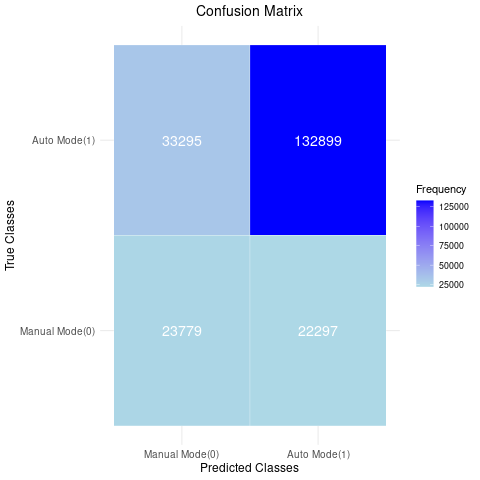

In [17]:
%%R
# Load required libraries
library(ggplot2)
library(caret)

# Map the values to labels (1 -> "Auto_mode", 0 -> "Manual")
predicted_classes_labeled <- factor(predicted_classes, levels = c(0,1), labels = c("Manual Mode(0)", "Auto Mode(1)"))
actual_classes_labeled <- factor (test_data$binaryDrivingMode, levels = c(0,1), labels = c("Manual Mode(0)", "Auto Mode(1)"))

# Generate the confusion matrix
cm <- confusionMatrix(predicted_classes_labeled, actual_classes_labeled)
cm_table <- as.data.frame(cm$table)

# Rename columns for better understanding
colnames(cm_table) <- c("Actual", "Predicted", "Frequency")

# Create the colored confusion matrix plot
ggplot(cm_table, aes(x = Predicted, y = Actual, fill = Frequency)) +
  geom_tile(color = "white") +
  scale_fill_gradient(low = "lightblue", high = "blue", name = "Frequency") +
  geom_text(aes(label = Frequency), color = "white", size = 5) +
  labs(title = "Confusion Matrix", x = "Predicted Classes", y = "True Classes") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, size = 14),
        axis.title = element_text(size = 12),
        axis.text = element_text(size = 10))

Area under the curve: 0.7725


Setting levels: control = 0, case = 1
Setting direction: controls < cases


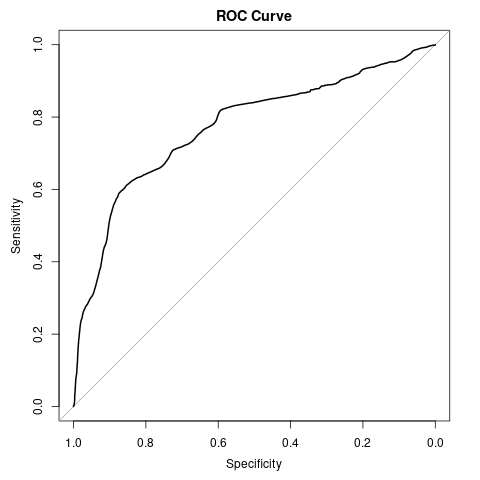

In [13]:
%%R

library(pROC)
roc_obj <- roc(test_data$binaryDrivingMode, predictions)
plot(roc_obj, main = "ROC Curve")
auc(roc_obj)

#### %%R
#Manually calculating the confusion matrix values
TP <- 132899
FP <- 22297
FN <- 33295
TN <- 23779

# Calculate Metrics
accuracy <- (TP + TN) / (TP + TN + FP + FN)
precision <- TP / (TP + FP)
recall <- TP / (TP + FN)

#Print Metrics
cat("Accuracy:", accuracy, "\n")
cat("Precision:", precision, "\n")
cat("Recall:", recall, "\n")

In [17]:
%%R
# Calculate Precision
precision <- sum(predicted_classes == 1 & test_data$binaryDrivingMode == 1) / sum(predicted_classes == 1)

# Calculate Recall
recall <- sum(predicted_classes == 1 & test_data$binaryDrivingMode == 1) / sum(test_data$binaryDrivingMode == 1)

# Calculate F1-Score
f1_score <- 2 * (precision * recall) / (precision + recall)

# Print the results
print(paste("Precision:", precision))
print(paste("Recall:", recall))
print(paste("F1-Score:", f1_score))

[1] "Precision: 0.799661840981022"
[1] "Recall: 0.856330060053094"
[1] "F1-Score: 0.827026354273624"
